In [12]:
# ==========================================================
# 1. Imports
# ==========================================================
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mannwhitneyu
import scikit_posthocs as sp

from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (make_scorer, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [13]:
# ==========================================================
# 2. Load datasets
# ==========================================================
DATA_DIR = Path("datasets")

datasets = {
    "MIR": pd.read_csv(DATA_DIR / "IST_MIR.csv"),
    "MOZ": pd.read_csv(DATA_DIR / "IST_MOZ.csv"),
    "OST": pd.read_csv(DATA_DIR / "IST_OST.csv"),
    "WIK": pd.read_csv(DATA_DIR / "IST_WIK.csv"),
}

# 12 properties defined in the original paper (Rahman & Williams, 2019)
FEATURES = [
    "Attribute", "Command", "Comment", "Ensure", "File", "File_mode",
    "Hard_coded_string", "Include", "Lines_of_code", "Require",
    "SSH_KEY", "URL"
]

In [14]:
# ==========================================================
# 3. Helper functions
# ==========================================================
def cliffs_delta(x, y):
    """
    Compute Cliff's Delta and qualitative magnitude.
    """
    x, y = np.array(x), np.array(y)
    nx, ny = len(x), len(y)
    greater = sum((xi > y).sum() for xi in x)
    less    = sum((xi < y).sum() for xi in x)
    delta   = (greater - less) / (nx * ny)
    d = abs(delta)
    if d < 0.14: mag = 'negligible'
    elif d < 0.33: mag = 'small'
    elif d < 0.47: mag = 'medium'
    else: mag = 'large'
    return delta, mag

def evaluate_models(X, y, model_dict):
    """
    Trains and evaluates each model with 10x10 CV and returns full scores
    and their medians.
    """
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)

    scorers = {
        'auc': 'roc_auc',
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }

    all_scores = {}
    medians    = {}

    for name, clf in model_dict.items():
        pipe = Pipeline([
            ("log", FunctionTransformer(lambda x: np.log1p(x))),
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=0.95, svd_solver="full")),
            ("clf", clf)
        ])
        scores = cross_validate(pipe, X, y, scoring=scorers,
                                cv=cv, n_jobs=-1, return_estimator=False)
        all_scores[name] = scores
        medians[name] = {m: np.median(scores[f"test_{m}"]) for m in scorers}
    return all_scores, medians

def scott_knott_table(scores_dict, metric="auc"):
    """
    Simple Scott–Knott-like ranking using pairwise Dunn test (via scikit-posthocs).
    Returns a sorted dataframe of model ranks.
    """
    # Convert all_scores to dataframe: each column is a model, each row a CV score
    df = pd.DataFrame({m: s[f"test_{metric}"] for m, s in scores_dict.items()})
    # Melt to long form
    melted = df.melt(var_name="model", value_name=metric)
    # Dunn’s test (non-parametric pairwise) – AHORA PASAMOS 'melted' CON group_col Y val_col
    dunn = sp.posthoc_dunn(melted, val_col=metric, group_col="model", p_adjust='holm')
    print(f"\nPairwise Dunn test p-values for {metric}:\n", dunn)
    return df

In [15]:
# ==========================================================
# 4. Models
# ==========================================================
models = {
    "CART": DecisionTreeClassifier(random_state=42),
    "KNN":  KNeighborsClassifier(),
    "LR":   LogisticRegression(max_iter=500, solver='liblinear'),
    "NB":   GaussianNB(),
    "RF":   RandomForestClassifier(n_estimators=200, random_state=42)
}


========== Dataset MIR ==========

Mann-Whitney U + Cliff’s Delta (defective vs non-defective):
Attribute            p= 0.0000  CliffΔ= 0.470 (large) ★
Command              p= 0.0000  CliffΔ= 0.243 (small) ★
Comment              p= 0.0000  CliffΔ= 0.369 (medium) ★
Ensure               p= 0.0000  CliffΔ= 0.382 (medium) ★
File                 p= 0.0000  CliffΔ= 0.365 (medium) ★
File_mode            p= 0.0000  CliffΔ= 0.409 (medium) ★
Hard_coded_string    p= 0.0000  CliffΔ= 0.551 (large) ★
Include              p= 0.0001  CliffΔ= 0.326 (small) ★
Lines_of_code        p= 0.0000  CliffΔ= 0.500 (large) ★
Require              p= 0.0000  CliffΔ= 0.356 (medium) ★
SSH_KEY              p= 0.0000  CliffΔ= 0.392 (medium) ★
URL                  p= 0.0002  CliffΔ= 0.225 (small) ★

Median scores over 10×10 CV:
CART | AUC=0.641  P=0.667  R=0.633  F1=0.636
KNN  | AUC=0.714  P=0.667  R=0.667  F1=0.667
LR   | AUC=0.752  P=0.696  R=0.667  F1=0.700
NB   | AUC=0.727  P=0.727  R=0.600  F1=0.667
RF   | AUC=0.73

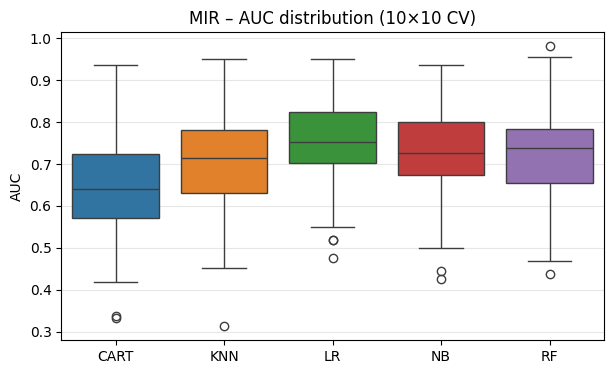


Pairwise Dunn test p-values for auc:
               CART       KNN            LR            NB        RF
CART  1.000000e+00  0.000571  1.687555e-11  5.490289e-07  0.000001
KNN   5.710814e-04  1.000000  1.090901e-02  4.197239e-01  0.419724
LR    1.687555e-11  0.010909  1.000000e+00  4.021140e-01  0.336986
NB    5.490289e-07  0.419724  4.021140e-01  1.000000e+00  0.851881
RF    1.362579e-06  0.419724  3.369860e-01  8.518808e-01  1.000000

========== Dataset MOZ ==========

Mann-Whitney U + Cliff’s Delta (defective vs non-defective):
Attribute            p= 0.0000  CliffΔ= 0.408 (medium) ★
Command              p= 0.0000  CliffΔ= 0.182 (small) ★
Comment              p= 0.2325  CliffΔ= 0.027 (negligible) 
Ensure               p= 0.0229  CliffΔ= 0.090 (negligible) ★
File                 p= 0.0000  CliffΔ= 0.184 (small) ★
File_mode            p= 0.0000  CliffΔ= 0.241 (small) ★
Hard_coded_string    p= 0.0000  CliffΔ= 0.405 (medium) ★
Include              p= 0.0000  CliffΔ= 0.313 (small) ★
Lin

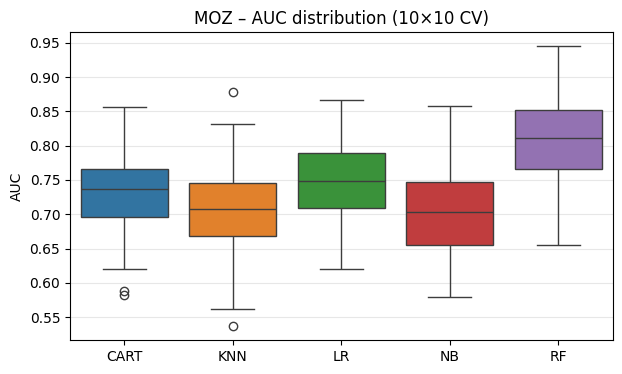


Pairwise Dunn test p-values for auc:
               CART           KNN            LR            NB            RF
CART  1.000000e+00  2.547064e-02  2.189225e-01  2.547064e-02  2.271315e-13
KNN   2.547064e-02  1.000000e+00  8.993725e-05  9.527779e-01  4.962345e-24
LR    2.189225e-01  8.993725e-05  1.000000e+00  9.790172e-05  1.340722e-08
NB    2.547064e-02  9.527779e-01  9.790172e-05  1.000000e+00  8.267692e-24
RF    2.271315e-13  4.962345e-24  1.340722e-08  8.267692e-24  1.000000e+00

========== Dataset OST ==========

Mann-Whitney U + Cliff’s Delta (defective vs non-defective):
Attribute            p= 0.0000  CliffΔ= 0.349 (medium) ★
Command              p= 0.0002  CliffΔ= 0.065 (negligible) ★
Comment              p= 0.4371  CliffΔ= 0.005 (negligible) 
Ensure               p= 0.0000  CliffΔ= 0.192 (small) ★
File                 p= 0.0000  CliffΔ= 0.085 (negligible) ★
File_mode            p= 0.0002  CliffΔ= 0.066 (negligible) ★
Hard_coded_string    p= 0.0000  CliffΔ= 0.374 (medium) ★
I

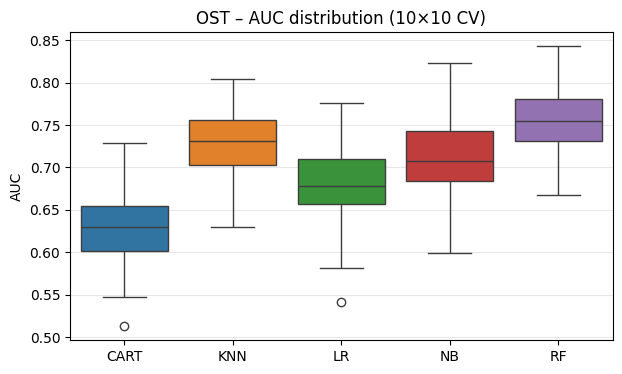


Pairwise Dunn test p-values for auc:
               CART           KNN            LR            NB            RF
CART  1.000000e+00  3.270462e-31  1.002532e-07  1.269976e-20  1.885901e-50
KNN   3.270462e-31  1.000000e+00  3.509335e-09  2.278769e-02  2.047374e-03
LR    1.002532e-07  3.509335e-09  1.000000e+00  2.684445e-04  1.807751e-20
NB    1.269976e-20  2.278769e-02  2.684445e-04  1.000000e+00  1.073486e-07
RF    1.885901e-50  2.047374e-03  1.807751e-20  1.073486e-07  1.000000e+00

========== Dataset WIK ==========

Mann-Whitney U + Cliff’s Delta (defective vs non-defective):
Attribute            p= 0.0000  CliffΔ= 0.473 (large) ★
Command              p= 0.0003  CliffΔ= 0.179 (small) ★
Comment              p= 0.0005  CliffΔ= 0.223 (small) ★
Ensure               p= 0.0000  CliffΔ= 0.288 (small) ★
File                 p= 0.0000  CliffΔ= 0.311 (small) ★
File_mode            p= 0.0000  CliffΔ= 0.238 (small) ★
Hard_coded_string    p= 0.0000  CliffΔ= 0.546 (large) ★
Include              p

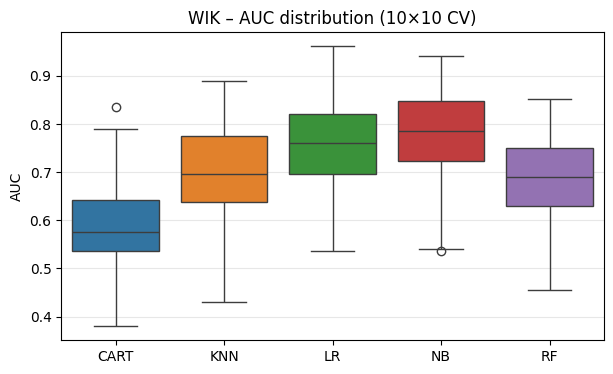


Pairwise Dunn test p-values for auc:
               CART           KNN            LR            NB            RF
CART  1.000000e+00  1.358985e-09  2.075367e-24  3.586383e-31  4.862450e-08
KNN   1.358985e-09  1.000000e+00  1.741959e-04  2.967433e-07  5.351999e-01
LR    2.075367e-24  1.741959e-04  1.000000e+00  3.228983e-01  1.389420e-05
NB    3.586383e-31  2.967433e-07  3.228983e-01  1.000000e+00  1.073195e-08
RF    4.862450e-08  5.351999e-01  1.389420e-05  1.073195e-08  1.000000e+00


In [16]:
# ==========================================================
# 5. Main loop: Evaluate each dataset
# ==========================================================
all_results   = {}
all_cv_scores = {}

for name, df in datasets.items():
    print(f"\n========== Dataset {name} ==========")
    df = df.copy().fillna(0)
    X = df[FEATURES].apply(pd.to_numeric, errors='coerce').fillna(0)
    y = df['defect_status'].astype(int)

    # ---------- Statistical tests for features ----------
    print("\nMann-Whitney U + Cliff’s Delta (defective vs non-defective):")
    for feat in FEATURES:
        d_val, mag = cliffs_delta(X[y==1][feat], X[y==0][feat])
        p_val = mannwhitneyu(X[y==1][feat], X[y==0][feat],
                             alternative='greater').pvalue
        sig = "★" if p_val < 0.05 else ""
        print(f"{feat:20s} p={p_val:>7.4f}  CliffΔ={d_val:>6.3f} ({mag}) {sig}")

    # ---------- Evaluate models ----------
    scores, med = evaluate_models(X, y, models)
    all_cv_scores[name] = scores
    all_results[name]   = med

    print("\nMedian scores over 10×10 CV:")
    for m, vals in med.items():
        print(f"{m:4s} | AUC={vals['auc']:.3f}  "
              f"P={vals['precision']:.3f}  "
              f"R={vals['recall']:.3f}  "
              f"F1={vals['f1']:.3f}")

    # ---------- Boxplot for each metric ----------
    df_auc = pd.DataFrame({mdl: scores[mdl]['test_auc'] for mdl in scores})
    plt.figure(figsize=(7,4))
    sns.boxplot(data=df_auc)
    plt.title(f"{name} – AUC distribution (10×10 CV)")
    plt.ylabel("AUC")
    plt.grid(True, axis='y', alpha=0.3)
    plt.show()

    # ---------- Scott–Knott-like table ----------
    scott_knott_table(scores, metric="auc")

In [17]:
# ==========================================================
# 6. Final summary table
# ==========================================================
print("\n\n============= FINAL SUMMARY (median scores) =============")
for ds, med in all_results.items():
    print(f"\n--- {ds} ---")
    for m, vals in med.items():
        print(f"{m:4s} -> {vals}")



============= FINAL SUMMARY (median scores) =============

--- MIR ---
CART -> {'auc': 0.640625, 'precision': 0.6666666666666666, 'recall': 0.6333333333333333, 'f1': 0.6363636363636364}
KNN  -> {'auc': 0.7142361111111111, 'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1': 0.6666666666666666}
LR   -> {'auc': 0.7515432098765432, 'precision': 0.6961538461538461, 'recall': 0.6666666666666666, 'f1': 0.7}
NB   -> {'auc': 0.7266975308641976, 'precision': 0.7272727272727273, 'recall': 0.6, 'f1': 0.6666666666666666}
RF   -> {'auc': 0.7391203703703704, 'precision': 0.6923076923076923, 'recall': 0.7, 'f1': 0.7}

--- MOZ ---
CART -> {'auc': 0.7361778846153846, 'precision': 0.6996779388083736, 'recall': 0.6923076923076923, 'f1': 0.6947648624667258}
KNN  -> {'auc': 0.7073317307692308, 'precision': 0.6363636363636364, 'recall': 0.5384615384615384, 'f1': 0.589572192513369}
LR   -> {'auc': 0.7490985576923077, 'precision': 0.68, 'recall': 0.5769230769230769, 'f1': 0.625}
NB   -> {'au